# Detecting Influential Observations

In [36]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot

In [37]:
# set random seed
np.random.seed()

# generate random data
n = 100
X = np.random.normal(0, 1, n)

# create a linear relationship with some noise
y = 2 + 3 * X + np.random.normal(0, 1, n)

In [38]:
# create dataframe
df = pd.DataFrame({
    'X': X,
    'y': y
})

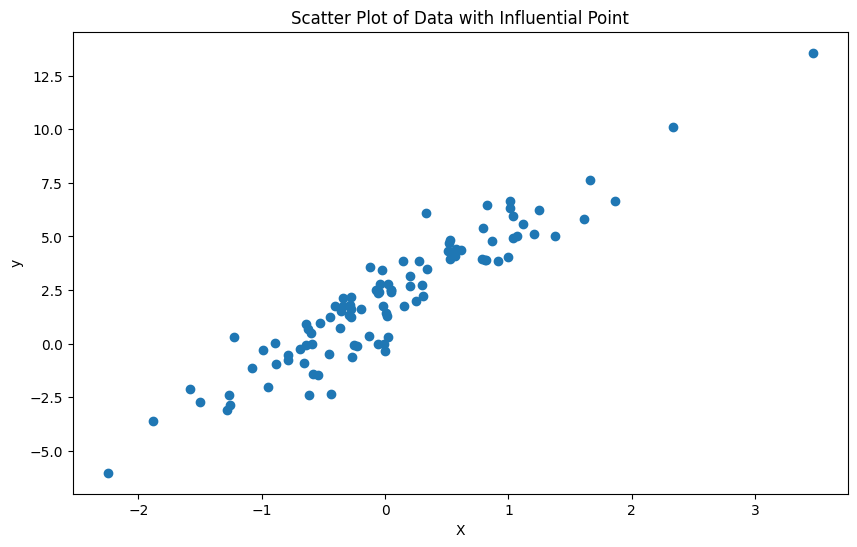

In [39]:
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['y'])
plt.title("Scatter Plot of Data with Influential Point")
plt.xlabel("X")
plt.ylabel("y")
# plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# add one influential point
df.loc[100] = [4, 20] # high leverage and outlier

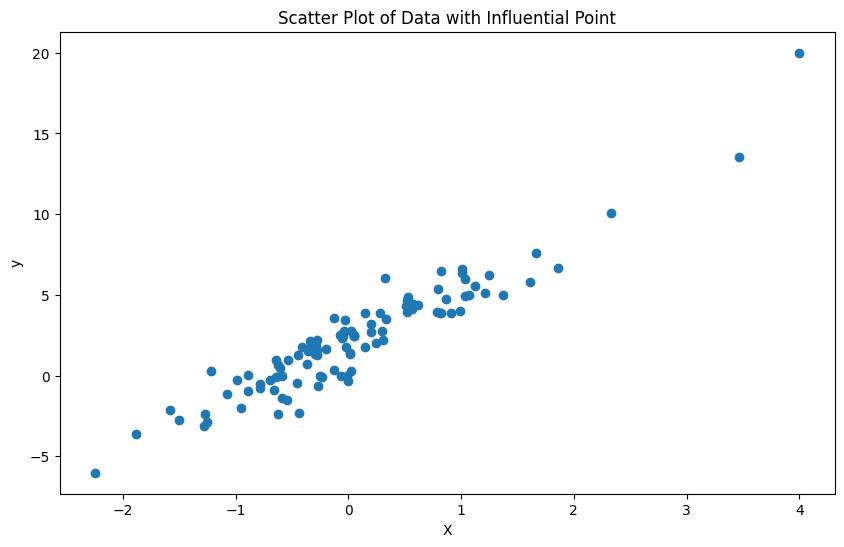

In [41]:
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['y'])
plt.title("Scatter Plot of Data with Influential Point")
plt.xlabel("X")
plt.ylabel("y")
# plt.grid(True, alpha=0.3)
plt.show()

In [42]:
# add constant (intercept) to the model
X_with_const = sm.add_constant(df["X"])

In [43]:
# fit model
model = sm.OLS(df['y'], X_with_const).fit()

In [44]:
# print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     826.8
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           7.40e-50
Time:                        22:59:19   Log-Likelihood:                -157.05
No. Observations:                 101   AIC:                             318.1
Df Residuals:                      99   BIC:                             323.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0311      0.115     17.594      0.0

### Residual Analysis

In [45]:
# calculate residuals
df['residuals'] = model.resid
df['abs_residuals'] = np.abs(model.resid)

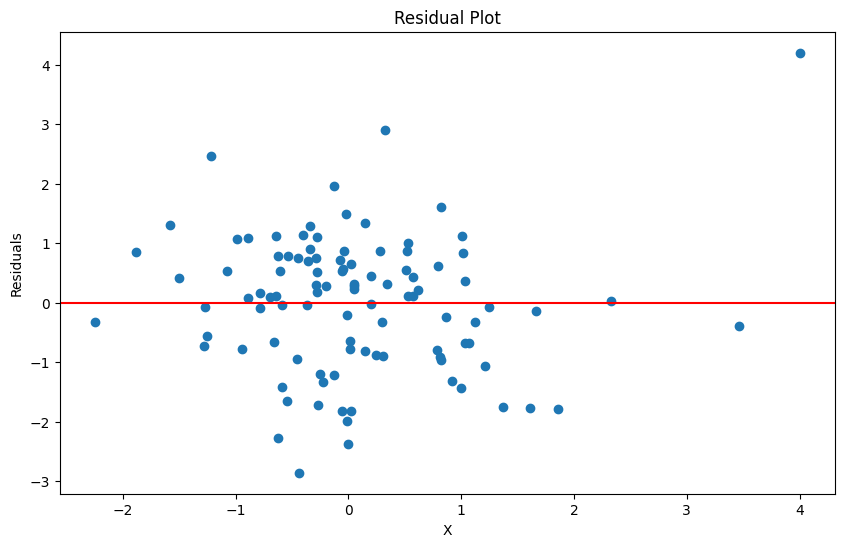

In [46]:
# plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df['residuals'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('X')
plt.ylabel('Residuals')
plt.show()

In [47]:
# identify potential outliers (residuals > 2 standard deviations)
residual_threshold = 2 * df['residuals'].std()
potential_outliers = df[df['abs_residuals'] > residual_threshold]

In [48]:
print(f"Potential outliers based on residuals (> {residual_threshold:.2f})")
print(potential_outliers)

Potential outliers based on residuals (> 2.30)
            X          y  residuals  abs_residuals
24  -1.221544   0.297610   2.469549       2.469549
29  -0.004724  -0.365979  -2.380829       2.380829
57   0.327708   6.067638   2.908970       2.908970
90  -0.441101  -2.348035  -2.861415       2.861415
100  4.000000  20.000000   4.205848       4.205848


### Leverage

In [49]:
# calculate leverage
df['leverage'] = model.get_influence().hat_matrix_diag

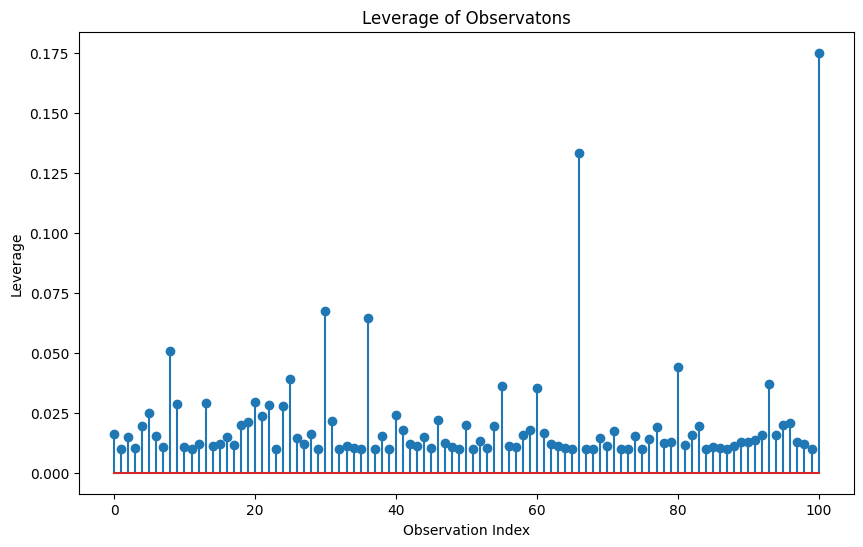

In [50]:
# plot leverage values
plt.figure(figsize=(10, 6))
plt.stem(df.index, df['leverage'])
plt.title('Leverage of Observatons')
plt.xlabel('Observation Index')
plt.ylabel('Leverage')
plt.show()

In [51]:
# indentify high leverage points (rule of thumb: leverage > 2(p+1)/n)
p = X_with_const.shape[1] - 1 # number of predictions (excluding constant)
leverage_threshold = 2 * (p + 1) / len(df)
high_leverage = df[df['leverage'] > leverage_threshold]

In [52]:
print(f"High leverage points (leverage > {leverage_threshold:.4f}):")
print(high_leverage)

High leverage points (leverage > 0.0396):
            X          y  residuals  abs_residuals  leverage
8   -1.881257  -3.588884   0.852972       0.852972  0.050572
30  -2.246935  -6.017625  -0.317560       0.317560  0.067254
36   2.330898  10.079670   0.028500       0.028500  0.064608
66   3.465448  13.563101  -0.391786       0.391786  0.133253
80   1.861843   6.648854  -1.788410       1.788410  0.044271
100  4.000000  20.000000   4.205848       4.205848  0.175136


### Cook's Distance

In [53]:
# calculate cook's distance
influence = model.get_influence()
cook = influence.cooks_distance[0]
df['cooks_d'] = cook

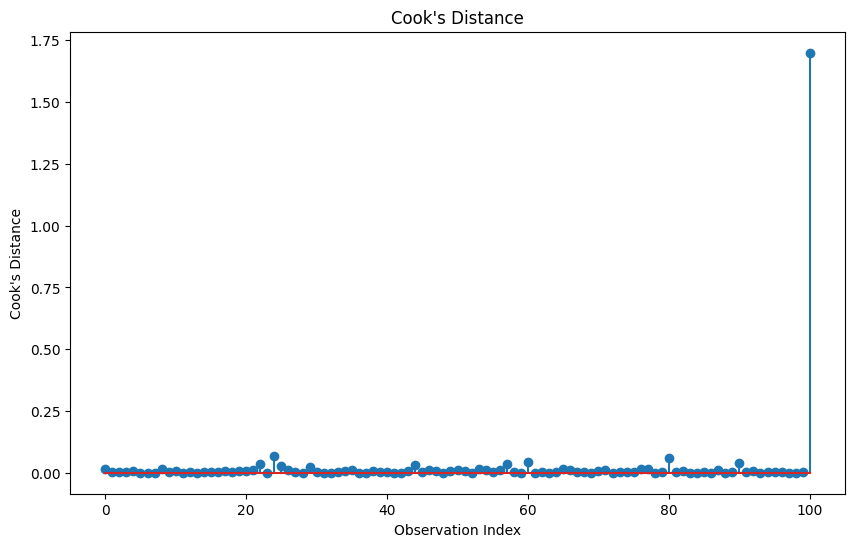

In [54]:
# plot cook's distance
plt.figure(figsize=(10, 6))
plt.stem(df.index, df['cooks_d'])
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

In [55]:
# identify influential points (rule of thumb: Cook's D > 4/n)
cooks_threshold = 4 / len(df)
influential_points = df[df['cooks_d'] > cooks_threshold]

In [56]:
print(f"Influential points (Cook's D > {cooks_threshold:.4f})")
print(influential_points)

Influential points (Cook's D > 0.0396)
            X          y  residuals  abs_residuals  leverage   cooks_d
24  -1.221544   0.297610   2.469549       2.469549  0.027710  0.066746
60   1.611525   5.807550  -1.768426       1.768426  0.035343  0.044348
80   1.861843   6.648854  -1.788410       1.788410  0.044271  0.057879
90  -0.441101  -2.348035  -2.861415       2.861415  0.012683  0.039776
100  4.000000  20.000000   4.205848       4.205848  0.175136  1.700022


### DFITS and DFBETAS

In [57]:
# calculate DFITS
df["dfits"] = influence.dffits[0]

In [58]:
# calculate DFBETAS
dfbetas = influence.dfbetas
df['dfbetas_const'] = dfbetas[:, 0]
df['dfbetas_X'] = dfbetas[:, 1]

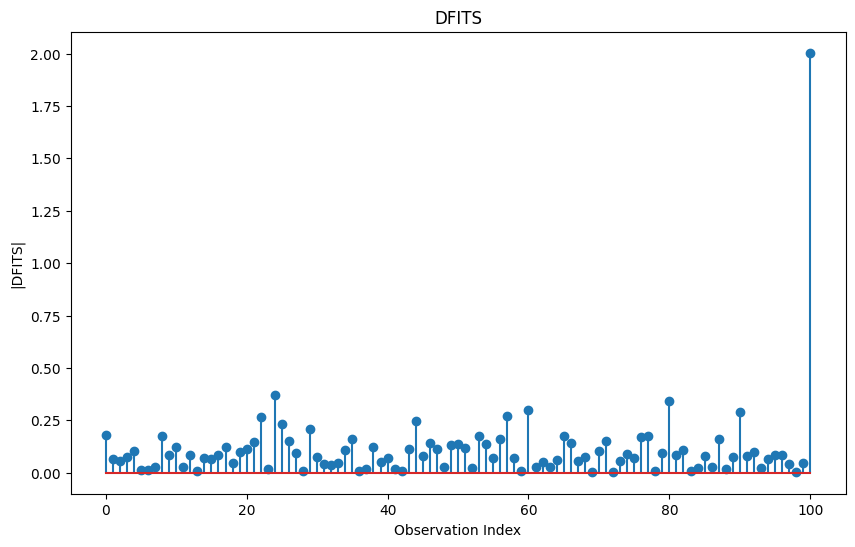

In [59]:
# plot dfits
plt.figure(figsize=(10, 6))
plt.stem(df.index, np.abs(df['dfits']))
plt.title('DFITS')
plt.xlabel('Observation Index')
plt.ylabel('|DFITS|')
plt.show()

In [60]:
# identify influential points based on DFITS (rule of thumb: |DFITS| > 2 * sqrt(p/n))
dfits_threshold = 2 * np.sqrt((p + 1) / len(df))
dfits_influential = df[np.abs(df["dfits"]) > dfits_threshold]

In [61]:
print(f"Influential points based on DFITS (|DFITS| > {dfits_threshold:.4f}):")
print(dfits_influential)

Influential points based on DFITS (|DFITS| > 0.2814):
            X          y  residuals  abs_residuals  leverage   cooks_d  \
24  -1.221544   0.297610   2.469549       2.469549  0.027710  0.066746   
60   1.611525   5.807550  -1.768426       1.768426  0.035343  0.044348   
80   1.861843   6.648854  -1.788410       1.788410  0.044271  0.057879   
90  -0.441101  -2.348035  -2.861415       2.861415  0.012683  0.039776   
100  4.000000  20.000000   4.205848       4.205848  0.175136  1.700022   

        dfits  dfbetas_const  dfbetas_X  
24   0.372432       0.243408  -0.298573  
60  -0.300001      -0.140170  -0.254535  
80  -0.342864      -0.140119  -0.302101  
90  -0.289833      -0.265130   0.135751  
100  2.003789       0.335988   1.946325  


### Influence Plot

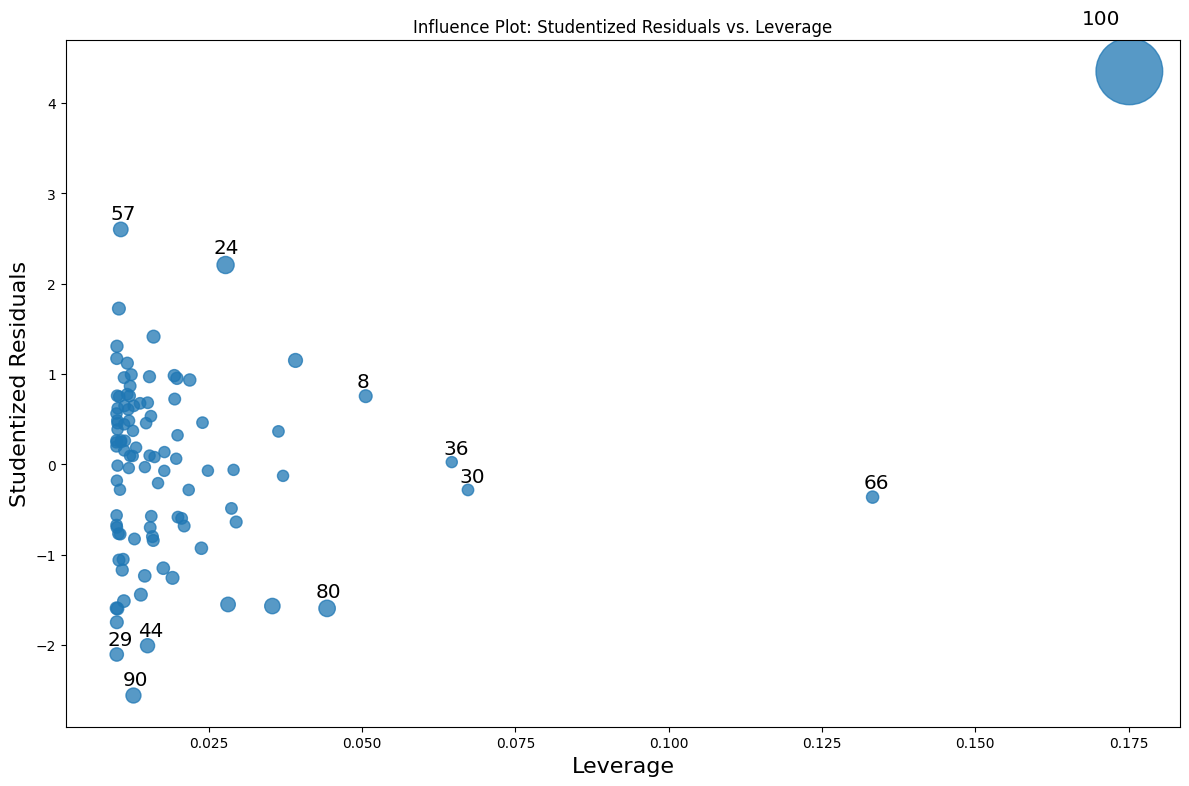

In [62]:
# create influence plot
fig, ax = plt.subplots(figsize=(12, 8))
influence_plot(model, ax=ax)
plt.title("Influence Plot: Studentized Residuals vs. Leverage")
plt.tight_layout()
plt.show()

### Handling Influential Observations

In [63]:
# Fit model without the influential point
clean_df = df[df.index != 100]
X_clean = sm.add_constant(clean_df["X"])
clean_model = sm.OLS(clean_df['y'], X_clean).fit()

In [64]:
# compare models
print("Original Model:")
print(f"Intercept: {model.params[0]:.4f}, Slope: {model.params[1]:.4f}, R-squared {model.rsquared:.4f}")

print("\nModel without influential point:")
print(f"Intercept: {clean_model.params[0]:.4f}, Slope: {clean_model.params[1]:.4f}. R-squared {clean_model.rsquared:.4f}")

Original Model:
Intercept: 2.0311, Slope: 3.4408, R-squared 0.8931

Model without influential point:
Intercept: 1.9954, Slope: 3.2264. R-squared 0.8795


C:\Users\riain\AppData\Local\Temp\ipykernel_23376\1828462230.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {model.params[0]:.4f}, Slope: {model.params[1]:.4f}, R-squared {model.rsquared:.4f}")
C:\Users\riain\AppData\Local\Temp\ipykernel_23376\1828462230.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {clean_model.params[0]:.4f}, Slope: {clean_model.params[1]:.4f}. R-squared {clean_model.rsquared:.4f}")


C:\Users\riain\AppData\Local\Temp\ipykernel_23376\604612429.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, model.params[0] + model.params[1] * x_range, 'b-', label=f'Original Model: y = {model.params[0]:.2f} + {model.params[1]:.2f}X')
C:\Users\riain\AppData\Local\Temp\ipykernel_23376\604612429.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, clean_model.params[0] + clean_model.params[1] * x_range, 'g--', label=f'Clean Model: y = {clean_model.params[0]:.2f} + {clean_model.params[1]:.2f}X')


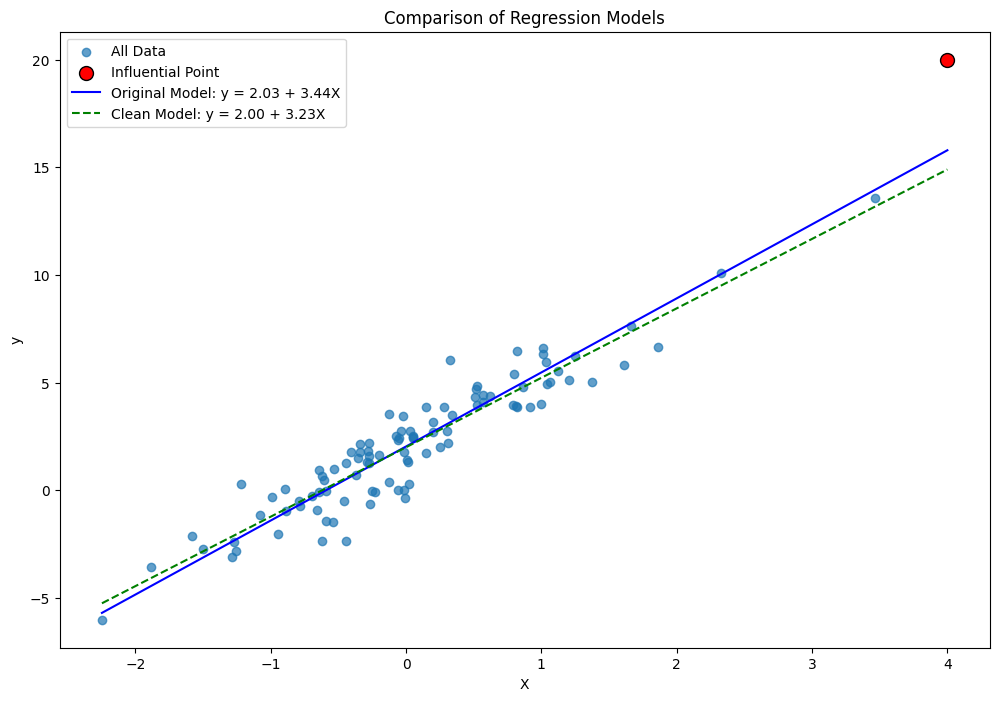

In [65]:
# Plot comparison
plt.figure(figsize=(12, 8))

# plot original data
plt.scatter(df['X'], df['y'], alpha=0.7, label='All Data')

# highlight influential point
plt.scatter(df.loc[100, 'X'], df.loc[100, 'y'], color='red', s=100, label="Influential Point", edgecolor='black')

# plot original regression line
x_range = np.linspace(df['X'].min(), df['X'].max(), 100)
plt.plot(x_range, model.params[0] + model.params[1] * x_range, 'b-', label=f'Original Model: y = {model.params[0]:.2f} + {model.params[1]:.2f}X')

# plot clean regression line
plt.plot(x_range, clean_model.params[0] + clean_model.params[1] * x_range, 'g--', label=f'Clean Model: y = {clean_model.params[0]:.2f} + {clean_model.params[1]:.2f}X')

plt.title("Comparison of Regression Models")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()